Goal
<Br>Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.
The data revolution has a lot to do with the fact that now we are able to collect all sorts of data
about people who buy something on our site as well as people who don't. This gives us a
tremendous opportunity to understand what's working well (and potentially scale it even further)
and what's not working well (and fix it).
**The goal of this challenge is to build a model that predicts conversion rate and, based on the
model, come up with ideas to improve revenue.**
This challenge is significantly easier than all others in this collection. There are no dates, no
tables to join, no feature engineering required, and the problem is really straightforward.
Therefore, it is a great starting point to get familiar with data science take-home challenges.
You should not move to the other challenges until you fully understand this one.
<Br>   
Challenge Description
<Br>
We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).
<Br>
**Your project is to:**
- Predict conversion rate
- Come up with recommendations for the product team and the marketing team to improve conversion rate   
<Br>

Data
<Br>
It has information about signed-in users during one session. Each row is a user session
<Br>
Columns:
- country : user country based on the IP address
- age : user age. Self-reported at sign-in step
- new_user : whether the user created the account during this session or had already an account and simply came back to the site
- source : marketing channel source
 - Ads: came to the site by clicking on an advertisement
 - Seo: came to the site by clicking on search results
 - Direct: came to the site by directly typing the URL on the browser
- total_pages_visited: number of total pages visited during the session. This is a proxy for
time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left
without buying anything. The company goal is to increase conversion rate: # conversions
/ total sessions.    

### 1. conversion rate

In [304]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures

from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.metrics import roc_auc_score
from sklearn import metrics
import seaborn as sns

In [134]:
df = pd.read_csv('https://raw.githubusercontent.com/SSSSYYYY/Take-home/master/1.conversion_rate.csv')

### Data explore

In [136]:
df.head()
df = df.drop('Unnamed: 0',axis = 1)
# 316200 rows × 6 columns

In [158]:
## check all the columns

for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d} \t {2:}'.format(column, len(uniques), df[column].dtype) ,'   ',uniques[:5])

country                  4 	 object     ['China', 'Germany', 'UK', 'US']
age                     60 	 int64     [17, 18, 19, 20, 21]
new_user                 2 	 int64     [0, 1]
source                   3 	 object     ['Ads', 'Direct', 'Seo']
total_pages_visited     29 	 int64     [1, 2, 3, 4, 5]
converted                2 	 int64     [0, 1]


In [18]:
## conversion rate
df.groupby('converted').converted.count()

## only 3% of the populaton converted

converted
0    306000
1     10200
Name: converted, dtype: int64

In [180]:
## conversion rate vs country

df.groupby(['country']).converted.agg(['count','mean'])

,count,mean
country,,
China,76602,0.00
Germany,13056,0.06
UK,48450,0.05
US,178092,0.04


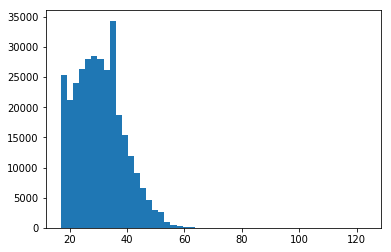

In [182]:
# age

plt.hist(df.age, bins = 50 )
plt.show()

# outlier detected

In [183]:
df[df.age > 70]
## two outlier found in 'age', will removed these records
## also detect small values

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
154217,US,73,1,Seo,5,0
192644,US,77,0,Direct,4,0
208969,US,72,1,Direct,4,0
265167,US,79,1,Direct,1,0
295581,UK,111,0,Ads,10,1


In [184]:
df = df[df.age < 80]

# df.age.loc[(df.Age < 18) | (df.Age > 80)] = np.nan
# df_age = df.age.dropna()

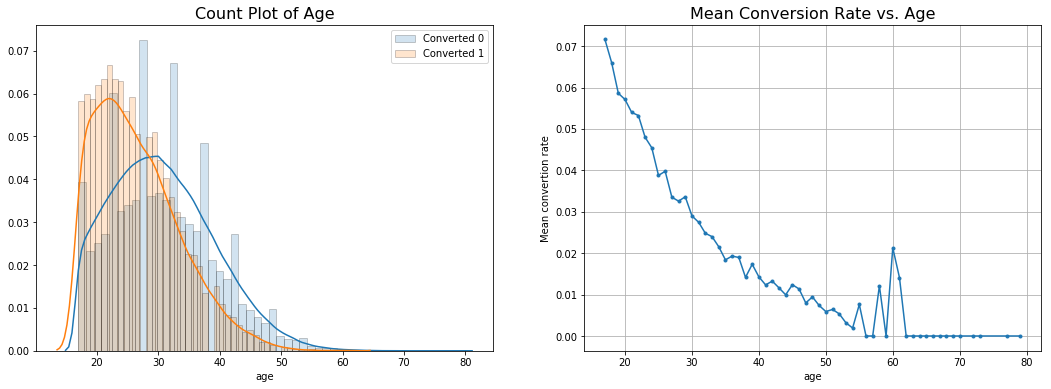

In [194]:
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df[df['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)

sns.distplot(df[df['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)

ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

In [224]:
# binning age into buckets, for modeling
bins = [17, 25, 33, 40, 50, 60, 80]
group_names = ['17-25','25-33','33-40','40-49', '50-59', '60+']

df['age_categories'] = pd.cut(df['age'], bins, labels=group_names)


In [192]:
df.groupby(['age_categories']).converted.agg(['count','mean'])

,count,mean
age_categories,,
17-25,89394,0.05
25-33,110690,0.03
33-40,68439,0.02
40-49,35355,0.01
50-59,4488,0.00
60+,235,0.00


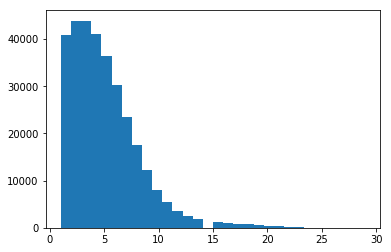

In [197]:
# total_pages_visited

plt.hist(df.total_pages_visited, bins = 30)
plt.show()

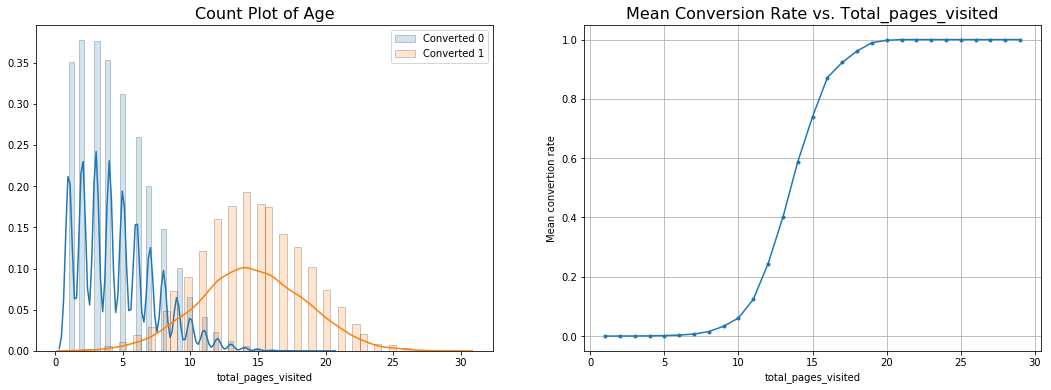

In [195]:

grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

sns.distplot(df[df['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Page viewed', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

In [250]:
# binning age into buckets, for modeling
bins2 = [0, 5,10,15,20,25,30]
group_names2 = ['0-5','5-10','10-15','15-20', '20-25', '25-30']

df['page_categories'] = pd.cut(df['total_pages_visited'], bins2, labels=group_names2)


In [208]:
df.groupby(['source']).converted.agg(['count','mean'])

,count,mean
source,,
Ads,88739,0.03
Direct,72420,0.03
Seo,155039,0.03


### Modeling

In [251]:
data_modeling = pd.get_dummies(df, prefix='country', columns=['country'],drop_first=True)
data_modeling = pd.get_dummies(data_modeling, prefix='new_user', columns=['new_user'],drop_first=True)
data_modeling = pd.get_dummies(data_modeling, prefix='source', columns=['source'],drop_first=True)
data_modeling = pd.get_dummies(data_modeling, prefix='age', columns=['age_categories'],drop_first=True)
data_modeling = pd.get_dummies(data_modeling, prefix='page', columns=['page_categories'],drop_first=True)

In [288]:
data_modeling = pd.get_dummies(df, prefix='country', columns=['country'])
data_modeling = pd.get_dummies(data_modeling, prefix='new_user', columns=['new_user'])
data_modeling = pd.get_dummies(data_modeling, prefix='source', columns=['source'])
data_modeling = pd.get_dummies(data_modeling, prefix='age', columns=['age_categories'])
data_modeling = pd.get_dummies(data_modeling, prefix='page', columns=['page_categories'])

In [289]:
data_y = data_modeling['converted']
data_modeling = data_modeling.drop(['converted','age','total_pages_visited'],axis = 1)

In [290]:
data_modeling.head()

,country_China,country_Germany,country_UK,country_US,new_user_0,new_user_1,source_Ads,source_Direct,source_Seo,age_17-25,...,age_33-40,age_40-49,age_50-59,age_60+,page_0-5,page_5-10,page_10-15,page_15-20,page_20-25,page_25-30
0,0,0,1,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [325]:
train_x, test_x, train_y, test_y= train_test_split(data_modeling, data_y, test_size = 0.25, random_state = 2019)

In [292]:
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=True)
# train_x = poly.fit_transform(train_x)
# test_x = poly.fit_transform(test_x)

## tried interaction terms , didn't improve the proformance

In [326]:
# sm = SMOTE(kind='regular',n_jobs=8,k_neighbors=9,m_neighbors=12)
# train_x, train_y= sm.fit_sample(train_x, train_y)

# sm = ADASYN(n_jobs=8)
# train_x, train_y = sm.fit_sample(train_x, train_y)

## tried smote didn't work out better

In [327]:
rf = RandomForestClassifier(n_estimators = 10, random_state = 2019, class_weight="balanced")
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=2019,
            verbose=0, warm_start=False)

In [328]:
print('accuracy :' ,metrics.accuracy_score(train_y, rf.predict(train_x))) 
print('ROC :' , metrics.roc_auc_score(train_y, rf.predict(train_x)))

accuracy : 0.9347875588240255
ROC : 0.9299529475472547


In [329]:
print(metrics.classification_report(train_y, rf.predict(train_x)))

             precision    recall  f1-score   support

          0       1.00      0.94      0.97    229490
          1       0.32      0.92      0.48      7658

avg / total       0.98      0.93      0.95    237148



In [330]:
cm = pd.DataFrame(metrics.confusion_matrix(train_y, rf.predict(train_x)), index = list(set(train_y)), columns = list(set(train_y)))

,0,1
0,214601,14889
1,576,7082


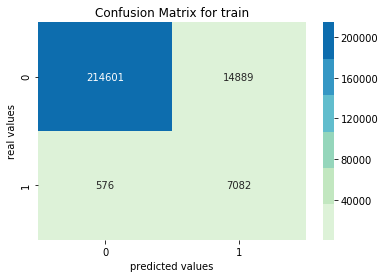

In [331]:

sns.heatmap(cm, annot = True, fmt='g',
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix for train')
display(cm)

In [332]:
print('accuracy :' ,metrics.accuracy_score(test_y, rf.predict(test_x))) 
print('ROC :' , metrics.roc_auc_score(test_y, rf.predict(test_x)))
print(metrics.classification_report(test_y, rf.predict(test_x)))

accuracy : 0.9355091714104997
ROC : 0.9286210335327482
             precision    recall  f1-score   support

          0       1.00      0.94      0.97     76510
          1       0.32      0.92      0.48      2540

avg / total       0.98      0.94      0.95     79050



,0,1
0,71612,4898
1,200,2340


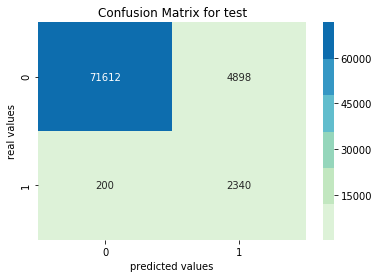

In [333]:
cm_t = pd.DataFrame(metrics.confusion_matrix(test_y, rf.predict(test_x)), index = list(set(test_y)), columns = list(set(test_y)))

sns.heatmap(cm_t, annot = True, fmt='g',
            cmap=sns.color_palette("GnBu")).set(xlabel='predicted values', 
                                                ylabel='real values', 
                                                title = 'Confusion Matrix for test')
display(cm_t)


In [334]:
# elavation cretira: the ability od detectiong the true converters
# 2340 / (2340 + 200) = 0.92%

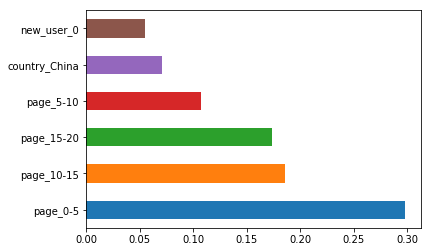

In [300]:
# feature importance

feat_importances = pd.Series(rf.feature_importances_, index=train_x.columns)
feat_importances.nlargest(6).plot(kind='barh')

<br>
<br>
<br>
### Note, binning the countinuous variables helped improve the reall of the test set which i thing tis the most important matrix 

#### recommendations

<br>
1. increase interaction of the first couple pages, to keep the visitor longer on the sight
2. people with more than 15 page views are less likely to convert, might investigate on the web design for further analysis
<br>
3. conversion rate accross country are very different, need to dig more on whether we have same marketing effort in those contries
4. yonger users are more likely to convert than older users, so we may disscuss with the marketing team to see why and to see if we can increase the marketing effort of the younger population